### Install Dependencies and Bring in Data

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [5]:
unzip_data("jigsaw-toxic-comment-classification-challenge.zip")

In [9]:
unzip_data("train.csv.zip")
unzip_data("test.csv.zip")
unzip_data("test_labels.csv.zip")
unzip_data("sample_submission.csv.zip")

In [11]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
df.iloc[4]['comment_text']

"You, sir, are my hero. Any chance you remember what page that's on?"

In [13]:
df[df.columns[2:]].iloc[4]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 4, dtype: int64

### 1. Preprocess

In [16]:
from tensorflow.keras.layers import TextVectorization

* TextVectorization - A preprocessing layer which maps text feature to integer sequences.

In [17]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [18]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [19]:
df[df.columns[2:]].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [21]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [22]:
# Number of words in the vocab
MAX_FEATURES = 200000

In [27]:
# Find the average number of tokens (words) in the comments
round(sum([len(i.split()) for i in x.values]) / len(x.values))

67

In [25]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = 100,
                               output_mode = 'int')

In [28]:
# Fit the vectorizer to the training data
# adapt: Fits the state of the preprocessing layer to the dataset
vectorizer.adapt(x.values)

In [29]:
vectorizer('Hello world, life is great')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([286, 261, 305,   9, 275], dtype=int64)>

In [34]:
vectorizer_text = vectorizer(x.values)

In [35]:
vectorizer_text

<tf.Tensor: shape=(159571, 100), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [37]:
# MCSHBAP - map, cache, shuffle, batch, prefetch from tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text , y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # Helps bottlenecks

In [40]:
batch_X , batch_y = dataset.as_numpy_iterator().next()

In [41]:
batch_X.shape

(16, 100)

In [42]:
batch_y.shape

(16, 6)

In [44]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [45]:
train_generator = train.as_numpy_iterator()

In [50]:
train_generator.next()

(array([[ 3613,    77,   302, ...,     0,     0,     0],
        [  136,   426,   127, ...,     0,     0,     0],
        [   86,   636,   178, ...,     0,     0,     0],
        ...,
        [   67,     2,  3415, ...,     0,     0,     0],
        [ 1347, 19784,    73, ...,     0,     0,     0],
        [ 7340,   128,    46, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

### 2. Create Sequential Model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dropout, Bidirectional, Embedding, Dense

In [54]:
model = Sequential()
# Create the embedding layer
# That plus 1 is for unknown word
model.add(Embedding(MAX_FEATURES + 1 , 32))
model.add(Bidirectional(LSTM(32 , activation = 'tanh')))
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(256 , activation = 'relu'))
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(6 , activation = 'sigmoid'))

In [56]:
y[0]

array([0, 0, 0, 0, 0, 0], dtype=int64)

In [57]:
# Compile the model
model.compile(loss = 'BinaryCrossentropy' , optimizer = 'Adam' , metrics = ['accuracy'])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [60]:
history = model.fit(train , epochs = 4, validation_data = val)

Epoch 1/4
6981/6981 [==============================] - 813s 116ms/step - loss: 0.0585 - accuracy: 0.9839 - val_loss: 0.0477 - val_accuracy: 0.9929
Epoch 2/4
6981/6981 [==============================] - 1386s 199ms/step - loss: 0.0462 - accuracy: 0.9913 - val_loss: 0.0411 - val_accuracy: 0.9940
Epoch 3/4
6981/6981 [==============================] - 1339s 192ms/step - loss: 0.0410 - accuracy: 0.9915 - val_loss: 0.0372 - val_accuracy: 0.9937
Epoch 4/4
6981/6981 [==============================] - 729s 104ms/step - loss: 0.0369 - accuracy: 0.9935 - val_loss: 0.0327 - val_accuracy: 0.9943


In [61]:
import matplotlib.pyplot as plt

In [65]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

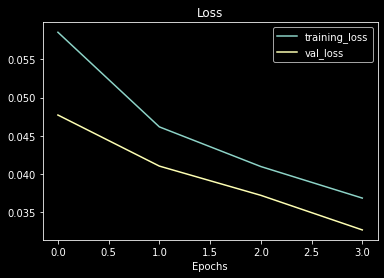

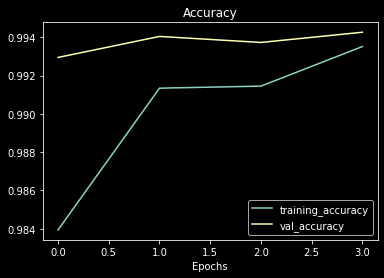

In [66]:
plot_loss_curves(history = history)

### 3. Make Predictions

In [69]:
input_text = vectorizer("You freaking suck!")

In [72]:
model.predict(np.expand_dims(input_text , 0))

array([[0.9987432 , 0.15864247, 0.9904302 , 0.00222608, 0.8398967 ,
        0.01920438]], dtype=float32)

In [73]:
batch_X , batch_y = test.as_numpy_iterator().next()

In [76]:
pred_probs = model.predict(batch_X)
pred_probs[]

array([[6.2070030e-05, 9.1445762e-16, 2.1394758e-06, 4.5563273e-09,
        1.9755880e-06, 6.8104757e-09],
       [6.4608175e-06, 4.9092239e-19, 5.9177353e-08, 8.8629284e-11,
        1.2355683e-07, 2.1968199e-10],
       [1.3736844e-02, 1.3684288e-08, 2.3491681e-03, 1.0663431e-05,
        1.2257695e-03, 2.2842652e-05],
       [1.8787384e-04, 5.5419882e-14, 7.4918421e-06, 6.4508860e-08,
        9.5826326e-06, 8.1870070e-08],
       [4.3916118e-01, 9.4676018e-04, 3.2485157e-02, 3.3240408e-02,
        5.8760941e-02, 1.9601822e-02]], dtype=float32)

In [78]:
preds = (model.predict(batch_X) > 0.5).astype(int)
preds[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [79]:
batch_y[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

### 4. Model Prediction

In [80]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [81]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy() 

In [86]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true , y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)
    # Flatten the prediction
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true , yhat)
    re.update_state(y_true , yhat)
    acc.update_state(y_true , yhat)

In [87]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision: 0.8681178092956543, Recall:0.7598767280578613, Accuracy:0.5025075078010559


### 5. Test and Gradio

In [90]:
# !pip install gradio jinja2

In [89]:
import gradio as gr

In [91]:
def score_commment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx , col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col , results[0][idx] > 0.5)
        
    return text

In [98]:
interface = gr.Interface(fn = score_commment,
                         inputs = gr.inputs.Textbox(lines = 2, placeholder = "Comment to score"),
                         outputs = 'text')

c:\Users\LENOVO\anaconda3\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\LENOVO\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\LENOVO\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\LENOVO\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [99]:
interface.launch(share = True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://11714.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x24c818b2cd0>,
 'http://127.0.0.1:7860/',
 'https://11714.gradio.app')